In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 21 11:04:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    43W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
DATA_DIR = "/content/gdrive/MyDrive/Colab Notebooks/Ftrain/Full Train"


In [ ]:
stats = (.5, .5, .5), (.5, .5, .5)


In [ ]:
transform_ds = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(*stats)
])
ds = torchvision.datasets.ImageFolder(root=DATA_DIR, transform=transform_ds)


In [ ]:
def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]


In [ ]:
batch_size = 64


In [ ]:
train_dl = DataLoader(ds, batch_size, shuffle=True, num_workers=8, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_image(train_dl):
    for images,_ in train_dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images.detach()[:32]), nrow=8).permute(1,2,0))
        break
        
#show_image(train_dl)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)
    
device = get_device()
device


device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)


In [ ]:
discriminator = nn.Sequential(
    #in: 128 x 3 x 128 x 128
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 64 x 64 x 64
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 128 x 32 x 32
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 256 x 16 x 16
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 512 x 8 x 8
    
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 1024 x 4 x 4
    
    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #128 x 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()

)

In [ ]:
discriminator = to_device(discriminator, device)


In [ ]:
latent_size=100


In [ ]:
generator = nn.Sequential(
    #in: 128 x 1 x 1
    
    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    #128 x 1024 x 4 x 4
    
    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #128 x 512 x 8 x 8
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #128 x 256 x 16 x 16
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #128 x 128 x 32 x 32
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #128 x 64 x 64 x 64
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    #128 x 3 x 128 x 128
    nn.Tanh()
    
    
)

In [ ]:
generator = to_device(generator, device)


In [ ]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    
    real_preds= discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    fake_preds= discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    loss = real_loss + fake_loss
    loss.backward(),
    opt_d.step()
    
    return loss.item(), real_score, fake_score


In [ ]:
def train_generator(opt_g):
    opt_g.zero_grad()
    
    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward(),
    opt_g.step()
    
    return loss.item()


In [ ]:
sample_dir = "/content/gdrive/MyDrive/Colab Notebooks/Ftrain/out"
os.makedirs(sample_dir, exist_ok=True)

In [ ]:

def save_sample(index, fixed_latent, show=True):
    fake_images = generator(fixed_latent)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()[:32], nrow=8).permute(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


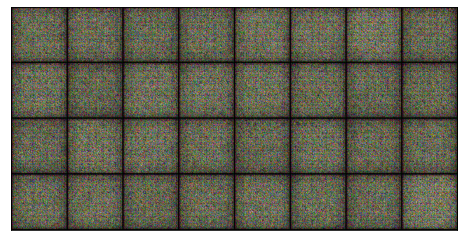

In [ ]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
save_sample(0, fixed_latent, show=True)


In [ ]:
#model = TheModelClass(*args, **kwargs)
####discriminator.load_state_dict(torch.load("/content/gdrive/MyDrive/Colab Notebooks/Ftrain/use_weights"))
#model.eval()

#model = TheModelClass(*args, **kwargs)
####generator.load_state_dict(torch.load("/content/gdrive/MyDrive/Colab Notebooks/Ftrain/use_weights"))
#model.eval()

In [ ]:
def fit(epochs, lr_d, lr_g, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        counter = 0
        for real_images,_ in tqdm(train_dl):
            real_images = real_images.cuda()
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
            counter += 1
            if(counter%30 == 0):
              print("counter at:",counter)
        print("counter finished:",counter)
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch: [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_d, loss_g, real_score, fake_score))
        if ((epoch+1) % 10) == 0:
          save_sample(epoch+start_idx, fixed_latent, show=False)
          torch.save(discriminator.state_dict(), "/content/gdrive/MyDrive/Colab Notebooks/Ftrain/weights/dis-state-dict")
          torch.save(discriminator, "/content/gdrive/MyDrive/Colab Notebooks/Ftrain/weights/dis-whole")
          torch.save(generator.state_dict(), "/content/gdrive/MyDrive/Colab Notebooks/Ftrain/weights/gen-state-dict")
          torch.save(generator, "/content/gdrive/MyDrive/Colab Notebooks/Ftrain/weights/gen-whole")
    
    return losses_d, losses_g, real_scores, fake_scores


In [ ]:
epochs = 300
#lr_d = 10e-5
#lr_g = 10e-4
lr_d = 3e-4
lr_g = 3e-4
history = [fit(epochs, lr_d, lr_g, start_idx=1)]

  0%|          | 0/128 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [1/300], loss_d: 0.8245, loss_g: 2.3810, real_score: 0.8945, fake_score: 0.4935


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [2/300], loss_d: 0.8645, loss_g: 5.1010, real_score: 0.8278, fake_score: 0.4635


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [3/300], loss_d: 0.8974, loss_g: 1.6804, real_score: 0.6148, fake_score: 0.2656


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [4/300], loss_d: 1.0091, loss_g: 2.0446, real_score: 0.6978, fake_score: 0.4572


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [5/300], loss_d: 0.8345, loss_g: 2.0442, real_score: 0.5264, fake_score: 0.0431


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [6/300], loss_d: 1.1857, loss_g: 4.5164, real_score: 0.7194, fake_score: 0.5357


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [7/300], loss_d: 1.4115, loss_g: 5.1737, real_score: 0.8597, fake_score: 0.6737


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [8/300], loss_d: 0.3775, loss_g: 5.7886, real_score: 0.9175, fake_score: 0.2366


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [9/300], loss_d: 0.5001, loss_g: 2.5094, real_score: 0.8239, fake_score: 0.2360


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [10/300], loss_d: 0.7025, loss_g: 3.7781, real_score: 0.8238, fake_score: 0.3401


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [11/300], loss_d: 2.0454, loss_g: 1.3395, real_score: 0.2156, fake_score: 0.0528


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [12/300], loss_d: 0.6004, loss_g: 3.9029, real_score: 0.8188, fake_score: 0.2743


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [13/300], loss_d: 1.5432, loss_g: 9.7116, real_score: 0.9855, fake_score: 0.7218


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [14/300], loss_d: 4.4824, loss_g: 2.9436, real_score: 0.0357, fake_score: 0.0019


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [15/300], loss_d: 1.2411, loss_g: 6.0845, real_score: 0.9614, fake_score: 0.6451


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [16/300], loss_d: 1.0425, loss_g: 6.7062, real_score: 0.8504, fake_score: 0.5294


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [17/300], loss_d: 0.5990, loss_g: 5.4813, real_score: 0.6006, fake_score: 0.0107


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [18/300], loss_d: 0.2120, loss_g: 5.2507, real_score: 0.9410, fake_score: 0.1302


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [19/300], loss_d: 0.0993, loss_g: 3.3440, real_score: 0.9167, fake_score: 0.0061


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [20/300], loss_d: 0.1478, loss_g: 3.5692, real_score: 0.9570, fake_score: 0.0926


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [21/300], loss_d: 0.4974, loss_g: 1.6664, real_score: 0.6786, fake_score: 0.0460


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [22/300], loss_d: 0.6254, loss_g: 9.5972, real_score: 0.9866, fake_score: 0.4037


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [23/300], loss_d: 0.0747, loss_g: 3.7712, real_score: 0.9653, fake_score: 0.0361


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [24/300], loss_d: 0.0367, loss_g: 6.5449, real_score: 0.9927, fake_score: 0.0285


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [25/300], loss_d: 2.5304, loss_g: 0.0039, real_score: 0.1356, fake_score: 0.0298


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [26/300], loss_d: 0.1353, loss_g: 5.2208, real_score: 0.9673, fake_score: 0.0870


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [27/300], loss_d: 1.1594, loss_g: 11.1271, real_score: 0.9998, fake_score: 0.5819


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [28/300], loss_d: 0.1159, loss_g: 7.8498, real_score: 0.9908, fake_score: 0.0685


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [29/300], loss_d: 0.0751, loss_g: 5.4768, real_score: 0.9796, fake_score: 0.0504


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [30/300], loss_d: 0.0981, loss_g: 1.8742, real_score: 0.9539, fake_score: 0.0425


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [31/300], loss_d: 2.4123, loss_g: 0.0141, real_score: 0.1307, fake_score: 0.0114


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [32/300], loss_d: 0.8214, loss_g: 9.3414, real_score: 0.9923, fake_score: 0.4215


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [33/300], loss_d: 0.2031, loss_g: 6.3526, real_score: 0.9489, fake_score: 0.1230


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [34/300], loss_d: 0.1103, loss_g: 4.1398, real_score: 0.9877, fake_score: 0.0839


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [35/300], loss_d: 0.6055, loss_g: 1.3827, real_score: 0.6164, fake_score: 0.0222


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [36/300], loss_d: 0.4206, loss_g: 7.6435, real_score: 0.7136, fake_score: 0.0016


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [37/300], loss_d: 0.8258, loss_g: 10.7941, real_score: 0.9705, fake_score: 0.4894


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [38/300], loss_d: 0.6103, loss_g: 6.7143, real_score: 0.9843, fake_score: 0.3775


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [39/300], loss_d: 0.0822, loss_g: 7.3115, real_score: 0.9362, fake_score: 0.0117


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [40/300], loss_d: 0.0099, loss_g: 9.8742, real_score: 0.9918, fake_score: 0.0014


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [41/300], loss_d: 0.3568, loss_g: 7.9388, real_score: 0.9095, fake_score: 0.1898


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [42/300], loss_d: 0.2280, loss_g: 3.9241, real_score: 0.9240, fake_score: 0.1169


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [43/300], loss_d: 0.2566, loss_g: 4.2713, real_score: 0.7890, fake_score: 0.0058


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [44/300], loss_d: 0.1222, loss_g: 3.9269, real_score: 0.9230, fake_score: 0.0371


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [45/300], loss_d: 3.0946, loss_g: 0.0002, real_score: 0.0754, fake_score: 0.0011


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [46/300], loss_d: 0.7234, loss_g: 0.3536, real_score: 0.6234, fake_score: 0.0113


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [47/300], loss_d: 1.1839, loss_g: 0.2644, real_score: 0.4537, fake_score: 0.1139


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [48/300], loss_d: 4.4204, loss_g: 0.0008, real_score: 0.0294, fake_score: 0.0128


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [49/300], loss_d: 0.6115, loss_g: 1.0313, real_score: 0.6405, fake_score: 0.0943


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [50/300], loss_d: 0.1532, loss_g: 9.8529, real_score: 0.8705, fake_score: 0.0023


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [51/300], loss_d: 1.4701, loss_g: 0.0247, real_score: 0.3524, fake_score: 0.0015


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [52/300], loss_d: 0.7841, loss_g: 1.0992, real_score: 0.6780, fake_score: 0.1110


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [53/300], loss_d: 2.5931, loss_g: 11.4474, real_score: 0.2230, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [54/300], loss_d: 1.2791, loss_g: 0.0289, real_score: 0.4283, fake_score: 0.0119


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [55/300], loss_d: 0.3160, loss_g: 3.5007, real_score: 0.7927, fake_score: 0.0057


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [56/300], loss_d: 0.4286, loss_g: 1.5662, real_score: 0.7334, fake_score: 0.0255


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [57/300], loss_d: 2.1470, loss_g: 21.0276, real_score: 0.9887, fake_score: 0.8136


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [58/300], loss_d: 0.0732, loss_g: 5.9720, real_score: 0.9441, fake_score: 0.0133


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [59/300], loss_d: 3.7534, loss_g: 13.1895, real_score: 0.1102, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [60/300], loss_d: 0.0764, loss_g: 12.0931, real_score: 0.9294, fake_score: 0.0001


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [61/300], loss_d: 0.1945, loss_g: 3.7528, real_score: 0.8718, fake_score: 0.0136


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [62/300], loss_d: 0.4037, loss_g: 6.9669, real_score: 0.9465, fake_score: 0.2359


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [63/300], loss_d: 0.0040, loss_g: 6.4349, real_score: 0.9962, fake_score: 0.0002


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [64/300], loss_d: 0.0457, loss_g: 5.9213, real_score: 0.9902, fake_score: 0.0336


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [65/300], loss_d: 0.0592, loss_g: 6.9171, real_score: 0.9765, fake_score: 0.0323


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [66/300], loss_d: 0.1605, loss_g: 12.7760, real_score: 0.8607, fake_score: 0.0001


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [67/300], loss_d: 0.0656, loss_g: 12.2275, real_score: 0.9433, fake_score: 0.0035


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [68/300], loss_d: 0.0143, loss_g: 6.4494, real_score: 0.9995, fake_score: 0.0132


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [69/300], loss_d: 0.0266, loss_g: 7.2769, real_score: 0.9826, fake_score: 0.0088


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [70/300], loss_d: 0.4273, loss_g: 3.8471, real_score: 0.8453, fake_score: 0.0255


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [71/300], loss_d: 0.4227, loss_g: 7.9429, real_score: 0.8927, fake_score: 0.0012


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [72/300], loss_d: 0.0954, loss_g: 6.0255, real_score: 0.9670, fake_score: 0.0533


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [73/300], loss_d: 0.1943, loss_g: 10.0761, real_score: 0.9812, fake_score: 0.1474


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [74/300], loss_d: 0.6290, loss_g: 1.5578, real_score: 0.7375, fake_score: 0.0693


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [75/300], loss_d: 0.0366, loss_g: 8.2331, real_score: 0.9818, fake_score: 0.0170


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [76/300], loss_d: 0.0344, loss_g: 10.3490, real_score: 0.9672, fake_score: 0.0003


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [77/300], loss_d: 0.3174, loss_g: 8.3311, real_score: 0.7684, fake_score: 0.0002


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [78/300], loss_d: 0.0015, loss_g: 11.1948, real_score: 0.9988, fake_score: 0.0002


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [79/300], loss_d: 0.2267, loss_g: 4.5815, real_score: 0.9744, fake_score: 0.1601


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [80/300], loss_d: 0.4841, loss_g: 1.7625, real_score: 0.7231, fake_score: 0.0405


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [81/300], loss_d: 0.0516, loss_g: 9.9438, real_score: 0.9572, fake_score: 0.0001


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [82/300], loss_d: 0.4874, loss_g: 2.6263, real_score: 0.7933, fake_score: 0.0532


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [83/300], loss_d: 0.0303, loss_g: 9.4390, real_score: 0.9961, fake_score: 0.0226


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [84/300], loss_d: 4.9778, loss_g: 0.6437, real_score: 0.0834, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [85/300], loss_d: 4.0839, loss_g: 0.9896, real_score: 0.0622, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [86/300], loss_d: 1.7246, loss_g: 0.0622, real_score: 0.3401, fake_score: 0.0003


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [87/300], loss_d: 0.2708, loss_g: 2.2105, real_score: 0.8272, fake_score: 0.0511


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [88/300], loss_d: 0.1850, loss_g: 5.2926, real_score: 0.9104, fake_score: 0.0716


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [89/300], loss_d: 0.3214, loss_g: 25.5043, real_score: 0.8000, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [90/300], loss_d: 0.0089, loss_g: 5.7014, real_score: 0.9986, fake_score: 0.0075


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [91/300], loss_d: 0.3525, loss_g: 1.9576, real_score: 0.7769, fake_score: 0.0413


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [92/300], loss_d: 0.1307, loss_g: 7.5957, real_score: 0.9989, fake_score: 0.0422


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [93/300], loss_d: 1.1930, loss_g: 0.8555, real_score: 0.4378, fake_score: 0.0041


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [94/300], loss_d: 0.7629, loss_g: 2.3202, real_score: 0.6432, fake_score: 0.0060


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [95/300], loss_d: 0.0503, loss_g: 7.3356, real_score: 0.9627, fake_score: 0.0105


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [96/300], loss_d: 1.1455, loss_g: 0.0303, real_score: 0.4122, fake_score: 0.0021


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [97/300], loss_d: 0.5979, loss_g: 16.1759, real_score: 0.8764, fake_score: 0.0035


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [98/300], loss_d: 1.0112, loss_g: 3.6738, real_score: 0.5683, fake_score: 0.0001


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [99/300], loss_d: 0.9201, loss_g: 0.1089, real_score: 0.5441, fake_score: 0.0065


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [100/300], loss_d: 0.0807, loss_g: 4.8049, real_score: 0.9547, fake_score: 0.0308


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [101/300], loss_d: 0.0783, loss_g: 5.6004, real_score: 0.9987, fake_score: 0.0674


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [102/300], loss_d: 0.1602, loss_g: 5.5127, real_score: 0.9993, fake_score: 0.1335


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [103/300], loss_d: 0.0653, loss_g: 6.9587, real_score: 0.9999, fake_score: 0.0512


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [104/300], loss_d: 0.0360, loss_g: 6.6457, real_score: 0.9764, fake_score: 0.0116


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [105/300], loss_d: 0.1586, loss_g: 3.0663, real_score: 0.9014, fake_score: 0.0038


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [106/300], loss_d: 2.6744, loss_g: 0.5633, real_score: 0.2540, fake_score: 0.0360


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [107/300], loss_d: 0.0425, loss_g: 7.3863, real_score: 0.9906, fake_score: 0.0307


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [108/300], loss_d: 0.9062, loss_g: 13.6539, real_score: 0.5512, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [109/300], loss_d: 6.5141, loss_g: 2.0531, real_score: 0.0033, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [110/300], loss_d: 0.0319, loss_g: 5.2399, real_score: 0.9784, fake_score: 0.0094


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [111/300], loss_d: 0.3631, loss_g: 5.5018, real_score: 0.7214, fake_score: 0.0030


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [112/300], loss_d: 0.0038, loss_g: 2.1681, real_score: 0.9994, fake_score: 0.0032


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [113/300], loss_d: 0.3213, loss_g: 4.5583, real_score: 0.8500, fake_score: 0.0818


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [114/300], loss_d: 0.0612, loss_g: 8.0144, real_score: 0.9891, fake_score: 0.0468


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [115/300], loss_d: 0.4133, loss_g: 5.9521, real_score: 0.7695, fake_score: 0.0023


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [116/300], loss_d: 0.1241, loss_g: 3.8355, real_score: 0.9084, fake_score: 0.0207


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [117/300], loss_d: 2.5478, loss_g: 8.9860, real_score: 0.2398, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [118/300], loss_d: 0.0432, loss_g: 6.0410, real_score: 0.9703, fake_score: 0.0111


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [119/300], loss_d: 0.0784, loss_g: 4.6843, real_score: 0.9499, fake_score: 0.0236


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [120/300], loss_d: 0.1366, loss_g: 9.9078, real_score: 0.9069, fake_score: 0.0013


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [121/300], loss_d: 1.8570, loss_g: 0.0011, real_score: 0.2753, fake_score: 0.0033


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [122/300], loss_d: 0.3849, loss_g: 3.6020, real_score: 0.7488, fake_score: 0.0020


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [123/300], loss_d: 0.0272, loss_g: 7.6478, real_score: 0.9897, fake_score: 0.0163


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [124/300], loss_d: 0.3450, loss_g: 14.6552, real_score: 0.9104, fake_score: 0.0004


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [125/300], loss_d: 0.0867, loss_g: 8.2443, real_score: 0.9977, fake_score: 0.0674


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [126/300], loss_d: 0.0522, loss_g: 5.6600, real_score: 0.9792, fake_score: 0.0299


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [127/300], loss_d: 0.4907, loss_g: 0.4115, real_score: 0.7064, fake_score: 0.0074


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [128/300], loss_d: 0.0474, loss_g: 7.0020, real_score: 0.9625, fake_score: 0.0055


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [129/300], loss_d: 0.0337, loss_g: 9.3883, real_score: 0.9986, fake_score: 0.0308


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [130/300], loss_d: 0.0809, loss_g: 8.3967, real_score: 0.9350, fake_score: 0.0047


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [131/300], loss_d: 0.6656, loss_g: 0.1298, real_score: 0.6257, fake_score: 0.0239


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [132/300], loss_d: 0.0358, loss_g: 5.7988, real_score: 0.9722, fake_score: 0.0060


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [133/300], loss_d: 0.0277, loss_g: 11.4927, real_score: 0.9765, fake_score: 0.0003


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [134/300], loss_d: 0.0419, loss_g: 5.0821, real_score: 0.9697, fake_score: 0.0101


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [135/300], loss_d: 1.8570, loss_g: 0.0191, real_score: 0.3400, fake_score: 0.0119


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [136/300], loss_d: 0.8684, loss_g: 13.3434, real_score: 0.9999, fake_score: 0.4216


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [137/300], loss_d: 0.0216, loss_g: 13.0570, real_score: 0.9812, fake_score: 0.0018


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [138/300], loss_d: 0.0459, loss_g: 8.9824, real_score: 0.9661, fake_score: 0.0063


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [139/300], loss_d: 0.8143, loss_g: 12.1163, real_score: 0.9821, fake_score: 0.4022


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [140/300], loss_d: 1.0197, loss_g: 1.7923, real_score: 0.6379, fake_score: 0.1255


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [141/300], loss_d: 0.5738, loss_g: 3.0712, real_score: 0.6416, fake_score: 0.0001


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [142/300], loss_d: 0.0220, loss_g: 16.2192, real_score: 0.9789, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [143/300], loss_d: 0.0157, loss_g: 6.0361, real_score: 0.9857, fake_score: 0.0011


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [144/300], loss_d: 0.1315, loss_g: 3.3734, real_score: 0.8906, fake_score: 0.0022


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [145/300], loss_d: 0.0177, loss_g: 7.4484, real_score: 0.9983, fake_score: 0.0157


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [146/300], loss_d: 0.6351, loss_g: 0.2259, real_score: 0.6667, fake_score: 0.0050


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [147/300], loss_d: 0.1325, loss_g: 4.2683, real_score: 0.9388, fake_score: 0.0474


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [148/300], loss_d: 0.0108, loss_g: 9.4350, real_score: 0.9905, fake_score: 0.0011


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [149/300], loss_d: 0.6997, loss_g: 0.5450, real_score: 0.6639, fake_score: 0.0212


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [150/300], loss_d: 1.2763, loss_g: 1.8652, real_score: 0.5033, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [151/300], loss_d: 0.0239, loss_g: 4.6647, real_score: 0.9816, fake_score: 0.0042


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [152/300], loss_d: 0.0173, loss_g: 10.7954, real_score: 0.9842, fake_score: 0.0007


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [153/300], loss_d: 0.3682, loss_g: 6.4644, real_score: 0.8797, fake_score: 0.1002


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [154/300], loss_d: 0.0246, loss_g: 10.3593, real_score: 0.9784, fake_score: 0.0020


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [155/300], loss_d: 0.0481, loss_g: 6.4689, real_score: 0.9876, fake_score: 0.0336


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [156/300], loss_d: 0.1008, loss_g: 4.8211, real_score: 0.9119, fake_score: 0.0041


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [157/300], loss_d: 0.1879, loss_g: 33.8354, real_score: 0.8846, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [158/300], loss_d: 0.0111, loss_g: 7.6623, real_score: 0.9923, fake_score: 0.0032


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [159/300], loss_d: 0.0803, loss_g: 3.8761, real_score: 0.9395, fake_score: 0.0042


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [160/300], loss_d: 0.0386, loss_g: 6.8292, real_score: 0.9962, fake_score: 0.0307


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [161/300], loss_d: 0.2491, loss_g: 3.6560, real_score: 0.8637, fake_score: 0.0166


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [162/300], loss_d: 0.0667, loss_g: 6.7425, real_score: 0.9624, fake_score: 0.0223


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [163/300], loss_d: 0.0622, loss_g: 6.6915, real_score: 0.9453, fake_score: 0.0030


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [164/300], loss_d: 0.0131, loss_g: 12.1620, real_score: 0.9958, fake_score: 0.0085


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [165/300], loss_d: 0.0061, loss_g: 7.0941, real_score: 0.9995, fake_score: 0.0054


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [166/300], loss_d: 4.2932, loss_g: 0.1759, real_score: 0.1126, fake_score: 0.0342


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [167/300], loss_d: 0.1934, loss_g: 8.6275, real_score: 0.9573, fake_score: 0.1155


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [168/300], loss_d: 0.8380, loss_g: 3.8154, real_score: 0.6471, fake_score: 0.1412


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [169/300], loss_d: 0.2802, loss_g: 10.9793, real_score: 0.8026, fake_score: 0.0001


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [170/300], loss_d: 0.2324, loss_g: 1.6907, real_score: 0.8339, fake_score: 0.0191


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [171/300], loss_d: 0.0412, loss_g: 6.4440, real_score: 0.9782, fake_score: 0.0165


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [172/300], loss_d: 0.0693, loss_g: 6.9623, real_score: 0.9374, fake_score: 0.0021


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [173/300], loss_d: 1.9312, loss_g: 8.9584, real_score: 0.3639, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [174/300], loss_d: 0.6771, loss_g: 0.1855, real_score: 0.6088, fake_score: 0.0079


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [175/300], loss_d: 0.2107, loss_g: 8.4748, real_score: 0.9153, fake_score: 0.0784


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [176/300], loss_d: 0.1121, loss_g: 17.8628, real_score: 0.9080, fake_score: 0.0001


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [177/300], loss_d: 0.1932, loss_g: 5.7356, real_score: 0.9280, fake_score: 0.0480


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [178/300], loss_d: 0.7088, loss_g: 0.6142, real_score: 0.6316, fake_score: 0.0153


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [179/300], loss_d: 1.6414, loss_g: 0.1683, real_score: 0.4735, fake_score: 0.1055


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [180/300], loss_d: 0.5060, loss_g: 10.6360, real_score: 1.0000, fake_score: 0.2912


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [181/300], loss_d: 1.5415, loss_g: 0.2501, real_score: 0.3772, fake_score: 0.0111


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [182/300], loss_d: 0.0519, loss_g: 5.8846, real_score: 0.9929, fake_score: 0.0407


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [183/300], loss_d: 2.5821, loss_g: 0.0045, real_score: 0.2815, fake_score: 0.0296


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [184/300], loss_d: 1.9047, loss_g: 0.1443, real_score: 0.3235, fake_score: 0.0023


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [185/300], loss_d: 0.1141, loss_g: 6.1385, real_score: 0.9896, fake_score: 0.0924


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [186/300], loss_d: 0.9324, loss_g: 1.6575, real_score: 0.5489, fake_score: 0.0011


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [187/300], loss_d: 0.0049, loss_g: 7.2035, real_score: 0.9986, fake_score: 0.0035


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [188/300], loss_d: 0.1462, loss_g: 4.1863, real_score: 0.9021, fake_score: 0.0156


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [189/300], loss_d: 0.0179, loss_g: 9.5992, real_score: 0.9995, fake_score: 0.0169


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [190/300], loss_d: 0.3124, loss_g: 1.4236, real_score: 0.7761, fake_score: 0.0144


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [191/300], loss_d: 0.0254, loss_g: 7.3456, real_score: 0.9808, fake_score: 0.0054


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [192/300], loss_d: 0.0408, loss_g: 6.1987, real_score: 0.9839, fake_score: 0.0223


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [193/300], loss_d: 1.5340, loss_g: 0.0105, real_score: 0.3687, fake_score: 0.0026


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [194/300], loss_d: 0.1312, loss_g: 7.7506, real_score: 0.9106, fake_score: 0.0258


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [195/300], loss_d: 0.1332, loss_g: 5.6154, real_score: 0.9716, fake_score: 0.0715


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [196/300], loss_d: 2.5827, loss_g: 0.1607, real_score: 0.1867, fake_score: 0.0006


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [197/300], loss_d: 0.3482, loss_g: 5.1331, real_score: 0.7708, fake_score: 0.0004


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [198/300], loss_d: 2.8451, loss_g: 0.0010, real_score: 0.1702, fake_score: 0.0113


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [199/300], loss_d: 0.3708, loss_g: 2.8130, real_score: 0.7634, fake_score: 0.0124


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [200/300], loss_d: 0.7636, loss_g: 0.2665, real_score: 0.5890, fake_score: 0.0120


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [201/300], loss_d: 0.0553, loss_g: 5.1502, real_score: 0.9651, fake_score: 0.0180


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [202/300], loss_d: 0.0107, loss_g: 6.1454, real_score: 0.9959, fake_score: 0.0064


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [203/300], loss_d: 0.5353, loss_g: 6.4643, real_score: 0.7820, fake_score: 0.1580


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [204/300], loss_d: 0.0114, loss_g: 7.4000, real_score: 0.9977, fake_score: 0.0082


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [205/300], loss_d: 0.0194, loss_g: 6.6566, real_score: 0.9839, fake_score: 0.0030


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [206/300], loss_d: 0.0821, loss_g: 8.1725, real_score: 0.9430, fake_score: 0.0057


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [207/300], loss_d: 0.0495, loss_g: 7.0524, real_score: 0.9955, fake_score: 0.0425


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [208/300], loss_d: 0.0370, loss_g: 5.1594, real_score: 0.9789, fake_score: 0.0108


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [209/300], loss_d: 0.1005, loss_g: 3.1585, real_score: 0.9467, fake_score: 0.0399


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [210/300], loss_d: 0.0620, loss_g: 15.7501, real_score: 0.9594, fake_score: 0.0007


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [211/300], loss_d: 0.0287, loss_g: 10.6153, real_score: 0.9901, fake_score: 0.0177


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [212/300], loss_d: 2.2445, loss_g: 0.0176, real_score: 0.2494, fake_score: 0.0503


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [213/300], loss_d: 0.0173, loss_g: 9.9875, real_score: 0.9845, fake_score: 0.0013


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [214/300], loss_d: 0.0268, loss_g: 6.4032, real_score: 0.9999, fake_score: 0.0257


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [215/300], loss_d: 2.8284, loss_g: 10.6219, real_score: 0.3010, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [216/300], loss_d: 0.0199, loss_g: 7.5433, real_score: 0.9998, fake_score: 0.0193


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [217/300], loss_d: 0.3270, loss_g: 3.8504, real_score: 0.7549, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [218/300], loss_d: 7.4768, loss_g: 0.0013, real_score: 0.0137, fake_score: 0.0034


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [219/300], loss_d: 0.0158, loss_g: 11.3571, real_score: 0.9964, fake_score: 0.0115


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [220/300], loss_d: 0.5169, loss_g: 3.3460, real_score: 0.7596, fake_score: 0.0300


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [221/300], loss_d: 0.4505, loss_g: 3.1870, real_score: 0.7974, fake_score: 0.0359


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [222/300], loss_d: 0.3043, loss_g: 2.9662, real_score: 0.7783, fake_score: 0.0031


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [223/300], loss_d: 1.0613, loss_g: 3.2568, real_score: 0.5725, fake_score: 0.0312


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [224/300], loss_d: 0.0127, loss_g: 15.6278, real_score: 0.9876, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [225/300], loss_d: 2.9314, loss_g: 0.0002, real_score: 0.1638, fake_score: 0.0025


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [226/300], loss_d: 0.5206, loss_g: 2.4153, real_score: 0.6791, fake_score: 0.0051


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [227/300], loss_d: 2.8017, loss_g: 0.5957, real_score: 0.2443, fake_score: 0.0001


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [228/300], loss_d: 0.2513, loss_g: 2.2036, real_score: 0.8158, fake_score: 0.0090


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [229/300], loss_d: 0.0895, loss_g: 2.9411, real_score: 0.9283, fake_score: 0.0093


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [230/300], loss_d: 0.0383, loss_g: 8.6992, real_score: 0.9992, fake_score: 0.0340


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [231/300], loss_d: 4.0814, loss_g: 0.0017, real_score: 0.1137, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [232/300], loss_d: 0.2745, loss_g: 3.4832, real_score: 0.8230, fake_score: 0.0180


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [233/300], loss_d: 0.1644, loss_g: 6.0299, real_score: 0.9995, fake_score: 0.1143


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [234/300], loss_d: 1.4860, loss_g: 0.4549, real_score: 0.3914, fake_score: 0.0024


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [235/300], loss_d: 5.3310, loss_g: 0.0251, real_score: 0.0325, fake_score: 0.0001


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [236/300], loss_d: 3.6146, loss_g: 0.0075, real_score: 0.1631, fake_score: 0.0041


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [237/300], loss_d: 4.0342, loss_g: 1.9789, real_score: 0.2132, fake_score: 0.5121


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [238/300], loss_d: 0.2190, loss_g: 4.2933, real_score: 0.8774, fake_score: 0.0457


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [239/300], loss_d: 0.4721, loss_g: 2.2633, real_score: 0.7592, fake_score: 0.0632


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [240/300], loss_d: 1.4453, loss_g: 1.8501, real_score: 0.4607, fake_score: 0.0109


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [241/300], loss_d: 0.2723, loss_g: 5.3598, real_score: 0.8202, fake_score: 0.0013


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [242/300], loss_d: 0.0172, loss_g: 14.5754, real_score: 0.9832, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [243/300], loss_d: 2.0027, loss_g: 0.0120, real_score: 0.3849, fake_score: 0.0056


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [244/300], loss_d: 2.0696, loss_g: 0.0515, real_score: 0.3585, fake_score: 0.0673


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [245/300], loss_d: 0.2398, loss_g: 3.1806, real_score: 0.8317, fake_score: 0.0296


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [246/300], loss_d: 1.6937, loss_g: 0.1524, real_score: 0.3495, fake_score: 0.0601


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [247/300], loss_d: 0.0192, loss_g: 9.4498, real_score: 0.9988, fake_score: 0.0173


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [248/300], loss_d: 0.3688, loss_g: 4.3591, real_score: 0.8552, fake_score: 0.0104


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [249/300], loss_d: 0.0786, loss_g: 8.8665, real_score: 0.9684, fake_score: 0.0411


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [250/300], loss_d: 0.0071, loss_g: 9.7659, real_score: 1.0000, fake_score: 0.0058


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [251/300], loss_d: 1.7405, loss_g: 0.3111, real_score: 0.5345, fake_score: 0.0125


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [252/300], loss_d: 0.3639, loss_g: 3.5581, real_score: 0.7821, fake_score: 0.0637


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [253/300], loss_d: 0.0159, loss_g: 7.6440, real_score: 0.9997, fake_score: 0.0132


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [254/300], loss_d: 0.1086, loss_g: 8.4751, real_score: 0.9667, fake_score: 0.0640


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [255/300], loss_d: 0.0121, loss_g: 8.6927, real_score: 0.9978, fake_score: 0.0098


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [256/300], loss_d: 0.8940, loss_g: 1.1451, real_score: 0.5568, fake_score: 0.0083


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [257/300], loss_d: 0.0147, loss_g: 14.5746, real_score: 0.9987, fake_score: 0.0121


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [258/300], loss_d: 0.2670, loss_g: 17.5189, real_score: 0.9996, fake_score: 0.1900


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [259/300], loss_d: 0.1625, loss_g: 11.0605, real_score: 0.9643, fake_score: 0.1010


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [260/300], loss_d: 0.6629, loss_g: 1.8293, real_score: 0.7019, fake_score: 0.0175


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [261/300], loss_d: 1.0500, loss_g: 0.1717, real_score: 0.5925, fake_score: 0.0015


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [262/300], loss_d: 0.1490, loss_g: 5.6934, real_score: 0.9403, fake_score: 0.0227


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [263/300], loss_d: 1.1249, loss_g: 6.0883, real_score: 0.5754, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [264/300], loss_d: 0.0132, loss_g: 8.4599, real_score: 0.9886, fake_score: 0.0014


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [265/300], loss_d: 0.6036, loss_g: 1.2198, real_score: 0.6727, fake_score: 0.0057


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [266/300], loss_d: 2.8164, loss_g: 0.0001, real_score: 0.2017, fake_score: 0.0307


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [267/300], loss_d: 2.3567, loss_g: 0.0160, real_score: 0.3019, fake_score: 0.0206


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [268/300], loss_d: 0.0045, loss_g: 10.4892, real_score: 0.9957, fake_score: 0.0002


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [269/300], loss_d: 2.4822, loss_g: 0.0040, real_score: 0.2640, fake_score: 0.0114


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [270/300], loss_d: 2.5972, loss_g: 0.0034, real_score: 0.2485, fake_score: 0.0371


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [271/300], loss_d: 0.0133, loss_g: 7.1145, real_score: 0.9941, fake_score: 0.0069


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [272/300], loss_d: 2.7050, loss_g: 0.0087, real_score: 0.2376, fake_score: 0.0002


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [273/300], loss_d: 0.3659, loss_g: 3.0169, real_score: 0.7706, fake_score: 0.0493


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [274/300], loss_d: 2.8108, loss_g: 0.0017, real_score: 0.2352, fake_score: 0.0173


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [275/300], loss_d: 0.7472, loss_g: 3.9507, real_score: 0.5778, fake_score: 0.0051


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [276/300], loss_d: 1.0699, loss_g: 1.3734, real_score: 0.5595, fake_score: 0.0015


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [277/300], loss_d: 0.6519, loss_g: 3.5669, real_score: 0.7108, fake_score: 0.0015


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [278/300], loss_d: 0.1330, loss_g: 4.2407, real_score: 0.8964, fake_score: 0.0071


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [279/300], loss_d: 3.2148, loss_g: 13.3653, real_score: 0.2460, fake_score: 0.0000


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [280/300], loss_d: 0.3049, loss_g: 2.1298, real_score: 0.8389, fake_score: 0.0244


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [281/300], loss_d: 0.1076, loss_g: 5.6122, real_score: 0.9265, fake_score: 0.0220


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [282/300], loss_d: 0.3315, loss_g: 1.2596, real_score: 0.7841, fake_score: 0.0078


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [283/300], loss_d: 1.6565, loss_g: 2.7674, real_score: 0.4130, fake_score: 0.0429


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [284/300], loss_d: 1.0984, loss_g: 0.5382, real_score: 0.5301, fake_score: 0.0011


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [285/300], loss_d: 0.1315, loss_g: 7.2738, real_score: 0.9998, fake_score: 0.1048


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [286/300], loss_d: 0.4104, loss_g: 0.9630, real_score: 0.7073, fake_score: 0.0111


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [287/300], loss_d: 2.6052, loss_g: 18.8489, real_score: 0.9999, fake_score: 0.7387


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [288/300], loss_d: 0.0359, loss_g: 5.0102, real_score: 0.9710, fake_score: 0.0054


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [289/300], loss_d: 2.1209, loss_g: 0.0505, real_score: 0.2788, fake_score: 0.0039


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [290/300], loss_d: 0.9417, loss_g: 3.5657, real_score: 0.5463, fake_score: 0.0148


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [291/300], loss_d: 0.7243, loss_g: 1.3924, real_score: 0.6604, fake_score: 0.0178


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [292/300], loss_d: 0.5769, loss_g: 1.6209, real_score: 0.7451, fake_score: 0.0087


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [293/300], loss_d: 0.7409, loss_g: 2.0262, real_score: 0.6710, fake_score: 0.0047


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [294/300], loss_d: 2.6830, loss_g: 0.0914, real_score: 0.2475, fake_score: 0.0121


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [295/300], loss_d: 0.1318, loss_g: 7.0371, real_score: 0.9086, fake_score: 0.0057


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [296/300], loss_d: 0.8076, loss_g: 1.5867, real_score: 0.6508, fake_score: 0.0246


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [297/300], loss_d: 0.7057, loss_g: 3.4534, real_score: 0.6424, fake_score: 0.0021


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [298/300], loss_d: 4.8442, loss_g: 0.3087, real_score: 0.1346, fake_score: 0.0015


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [299/300], loss_d: 0.7963, loss_g: 0.9001, real_score: 0.6546, fake_score: 0.0063


  0%|          | 0/128 [00:00<?, ?it/s]

counter at: 30
counter at: 60
counter at: 90
counter at: 120
counter finished: 128
Epoch: [300/300], loss_d: 0.4373, loss_g: 11.8357, real_score: 0.7694, fake_score: 0.0018


In [ ]:
print("DONE")

DONE


In [ ]:
'''
google colab for training the gpu
pytorch:
    ex: pre-trained vgg for style transfer
    etc...

kaggle: for datasets
'''

In [ ]:
#latent = torch.randn(128, latent_size, 1, 1, device=device)
import random
letters = "asd"

latent = [random.random() for _ in range(100)]
latent = [ord(letter) - 96 for letter in letters]
print(latent)
if len(latent) < 100:
  while len(latent)<100:
    latent.append(0)
latent = torch.FloatTensor(latent)

print(latent)

[1, 19, 4]
tensor([ 1., 19.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.])
